<a href="https://colab.research.google.com/github/longxuyi/Stanford/blob/main/CS109/Sampling_and_Bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling and the Bootstrap

_Courtesy of Lisa Yan_

In [2]:
# Important!!!! Run this cell before running anything else!!!
import copy
import requests

url_dir = "http://web.stanford.edu/class/cs109/demos/bootstrap/"
for fname in ["bhutanese_pop.csv", "bhutanese_sample.csv",
              "p1.csv", "p2.csv",
              "population.py", # used for regenerating the population if needed
              "util.py"]:
    url = "{}/{}".format(url_dir, fname)
    myfile = requests.get(url)
    with open(fname, 'wb') as f:
        f.write(myfile.content)

from util import *

# allows simple graphs
%matplotlib inline
%load_ext autoreload
%autoreload 2

# statistics: load the population and sample
with open('bhutanese_pop.csv', 'r') as f:
    pop = [int(line.strip()) for line in f.readlines()]
with open('bhutanese_sample.csv', 'r') as f:
    sample = [int(line.strip()) for line in f.readlines()]

# hypothesis testing: load our data
with open('p1.csv', 'r') as f:
    sample1 = [float(line.strip()) for line in f.readlines()]
with open('p2.csv', 'r') as f:
    sample2 = [float(line.strip()) for line in f.readlines()]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Population statistics

While the population of Bhutan is actually closer to $800000$, in this example we assume that the kingdom of Bhutan has $N=10000$ people. As the King (or Queen) of Bhutan, you would like to measure the average happiness of your kingdom, where happiness is measured on a scale of 1 to 150.

The distribution of happiness in your population is graphed below, along with a few **population statistics**.

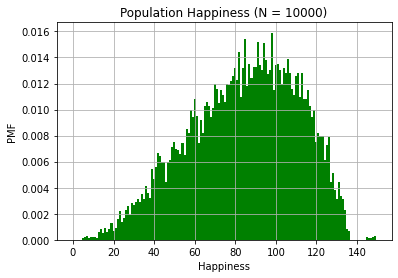

population size, N = 10000
mean happiness , mu = 84.26
var happiness, sigma^2 = 711.72
std deviation happiness, sigma = 26.68


In [3]:
fig1 = plt.figure(1)

plot_population(fig1, pop, "happiness")
mu, sigma_sq, sigma = get_pop_statistics(pop, "happiness")

# 2. Our Sample

Since it is infeasible to survey all 10,000 Bhutanese people, you instead pick a **sample** of $n = 200$ citizens, and use this sample to compute sample statistics. These are estimates of your true population statistics.

You do **not** know the population distribution (from the previous codeblock), but you know that each of the $n$ datapoints in your sample is chosen randomly (with replacement) from the $N$ datapoints in your population. In other words, the $n$ datapoints $X_1, X_2, \dots, X_n$ are independent and identically distributed (i.i.d.) according to the unknown population distribution.

The particular sample you choose (i.e., the **realization** of the sample) is graphed below.

/content/util.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(int, ax.get_xticks()), fontsize=16)


Sample mean 83.03


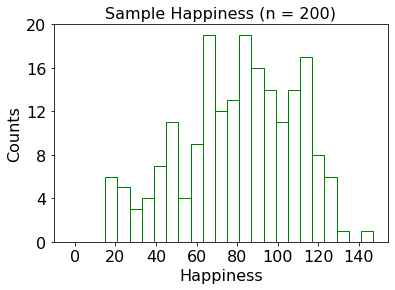

population size, N = 10000
mean happiness , mu = 84.26
var happiness, sigma^2 = 711.72
std deviation happiness, sigma = 26.68


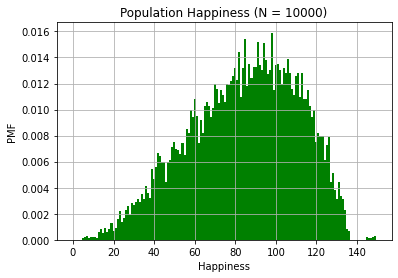

In [4]:
fig2= plt.figure(2)
plot_sample(fig2, sample, "happiness", binwidth=6)

get_pop_statistics(pop, "happiness")
fig1 = plt.figure(1)
plot_population(fig1, pop, "happiness")

## Sample statistics

Using this small sample of sample size $n=200$, you would like to estimate the mean happiness $\mu$ and the variance of happiness $\sigma^2$.

You can compute **unbiased** estimates of your population mean $\mu$ and variance $\sigma^2$:

* $\bar{X}$ is the sample mean, which is simply the mean of your sample.
* $S^2$ is the sample variance, which is computed via the formula $S^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2$. You can compute this via NumPy using ```np.var(sample, ddof=1)``` (the ```ddof=1``` argument allows you to divide by $n-1$, instead of $n$). Below we verify that this is exactly what you should be calculating.

**IMPORTANT NOTE:** The sample mean computed below is just the mean of this particular sample. If your sample were a different set of $n=200$ datapoints from the population, your sample mean will evidently be different. In other words, the sample mean is a random variable that arises from the $n$ i.i.d. random variables of your sample! This is just a particular realization of the sample mean. The same goes for the computed sample variance.

In [ ]:
mu, sigma_sq, sigma = get_pop_statistics(pop, "happiness")

print()
print('sample mean', np.mean(sample))
print('sample variance', np.var(sample, ddof=1))

# verifying sample variance via different approach
tot_dev = 0
bar_x = np.mean(sample)
for s in sample:
    tot_dev += (s - bar_x) ** 2
s_sq = tot_dev/(len(sample) - 1)
print('verifying sample variance: ', s_sq)

population size, N = 10000
mean happiness , mu = 84.26
var happiness, sigma^2 = 711.72
std deviation happiness, sigma = 26.68

sample mean 83.03
sample variance 793.7076381909548
verifying sample variance:  793.707638190955


The sample mean is an unbiased estimate of the population mean, meaning $E[\bar{X}] = \mu$. If the sample mean is a random variable, it will deviate (i.e., *vary*) from the population mean. By the Central Limit Theorem, $\bar{X} \sim \mathcal{N}(\mu, \frac{\sigma^2}{n}$).

Even if we want to categorize the variance of the sample mean, from just our sample we do not know $\sigma^2/n$, which depends on the population variance. We therefore provide an *estimate* of the variance of the sample mean.

Typically, we report our estimate of the standard deviation of the sample mean. This is known as *standard error*. $SE = \sqrt{\frac{S^2}{n}}=\frac{S}{\sqrt{n}}$. You can compute this via NumPy using ```np.std(sample, ddof=1)/np.sqrt(len(sample))```.

In [ ]:
print('standard error', np.std(sample, ddof=1)/np.sqrt(len(sample)))
print('verifying standard error', np.sqrt(s_sq/len(sample)))

standard error 1.9921190202783503
verifying standard error 1.9921190202783505


# 3. Distribution of sample means

As mentioned earlier, the sample mean is a **random variable**. The sample mean computed, $\bar{X} = 83.03$, is just a *particular realization* of the sample mean, dependent on us sampling the exact sample that we plotted in the second figure ("Sample Happiness").

Below we plot a distribution of sample means of $10000$ samples (each of size $n = 200$) gathered from our population. Note that our sample mean $\bar{X} = 83.03$ is just one of these.

In [ ]:
NSAMPLE = 200

# generate a whole bunch of sample means
means = []
for i in range(10000):
    subsample = random.sample(pop, NSAMPLE)
    means.append(np.mean(subsample))

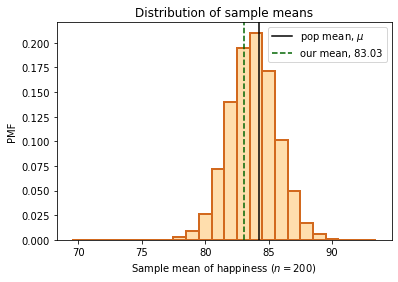

In [ ]:
fig3 = plt.figure(3)
plot_sample_means(fig3, means, mu, bar_x)

Why does it make sense that our sample mean is centered around the population mean $\mu = 84.26$ with such a small variance? Remember that by the Central Limit Theorem, $\bar{X} \sim N(\mu, \frac{\sigma^2}{n}$). We show that the mean and variance of the $10000$ sample means that we computed are close to $\mu$ and $\frac{\sigma^2}{n}$, respectively.

In [ ]:
print('Population mean', mu)
print('mean of sample means', np.mean(means))
print()
print('Population variance/n', sigma_sq/NSAMPLE)
print('variance of sample means', np.var(means))
print('standard deviation of sample means', np.std(means))

Population mean 84.2582
mean of sample means 84.27322550000001

Population variance/n 3.5585936638000004
variance of sample means 3.47364470864975
standard deviation of sample means 1.8637716353270726


Again, if we just had our one sample collected from Section 2, we cannot report the variance of sample means because we cannot not know the population variance from just one sample. So we estimate the population variance, then report **standard error**, which is an unbiased estimate of the standard deviation of sample means. $SE = S/\sqrt{n}$, where $S$ is the sample variance.

In [ ]:
print('standard error', np.std(sample, ddof=1)/np.sqrt(len(sample)))

standard error 1.9921190202783503


# 4. Distribution of sample variances

If we can report our $\bar{X}$, our estimate for population mean, and report standard error $SE$, can we report some form of error/variance for $S^2$, our estimate for population variance?

You could if you wanted to, but a close form of the variance of sample variance is beyond the scope of this class. Instead, try bootstrapping, which we discuss next!

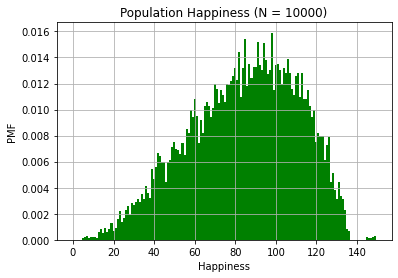

In [ ]:
fig1 = plt.figure(1)
plot_population(fig1, pop, "happiness")


# 5. The Bootstrap

The Bootstrap is a newly invented statistical technique for both understanding distributions of statistics and for calculating $p$-values (a $p$-value is a the probability that a scientific claim is incorrect). It was invented here at Stanford in 1979 when mathematicians were just starting to understand how computers, and computer simulations, could be used to better understand probabilities.

The first key insight is that: if we had access to the underlying distribution ($F$) then answering almost any question we might have as to how accurate our statistics are becomes straightforward. 

The next insight behind bootstrapping is that the best estimate that we can get for $F$ is from our sample itself!

The bootstrap algorithm, as described in class, is as follows:

1. Estimate the PMF using the sample
1. Repeat 10,000 times: 

    1. Resample sample.size() from PMF 
    1. Recalculate the statistic on the resample

1. You now have a distribution of your statistic

Let's try out the bootstrapping procedure for determining a distribution over the sample variance.

## Step 5.1. Estimate the PMF using the sample

The simplest way to estimate $F$ (and the one we will use in this class) is to assume:

$$P(X=k)= \frac{\text{# values in sample equal to k}}{n}$$

[27, 110, 74, 72, 131, 75, 91, 89, 123, 68, 83, 57, 110, 109, 77, 126, 54, 95, 53, 100, 43, 84, 64, 76, 91, 104, 111, 110, 35, 61, 85, 79, 91, 77, 116, 45, 66, 91, 109, 92, 114, 85, 50, 116, 20, 83, 98, 123, 87, 76, 98, 87, 44, 78, 120, 84, 56, 48, 23, 94, 113, 44, 106, 88, 49, 67, 66, 44, 120, 97, 102, 114, 70, 118, 109, 110, 89, 87, 71, 73, 113, 110, 122, 84, 66, 76, 88, 107, 23, 92, 23, 75, 85, 94, 77, 94, 25, 101, 100, 115, 147, 85, 62, 114, 34, 104, 128, 121, 82, 70, 68, 42, 34, 53, 105, 63, 92, 127, 45, 23, 119, 116, 92, 128, 99, 98, 67, 69, 98, 29, 107, 87, 38, 52, 36, 83, 70, 69, 104, 107, 106, 82, 84, 132, 76, 51, 93, 87, 115, 67, 123, 112, 60, 64, 116, 117, 105, 85, 126, 60, 69, 97, 98, 99, 118, 52, 111, 64, 90, 114, 82, 116, 68, 51, 38, 93, 79, 66, 98, 48, 78, 25, 52, 62, 84, 80, 119, 78, 99, 26, 57, 70, 70, 90, 36, 119, 109, 122, 83, 23]
Sample mean 83.03


/content/util.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str('%.3f' % x)[1:] for x in ax.get_yticks()], fontsize=16)


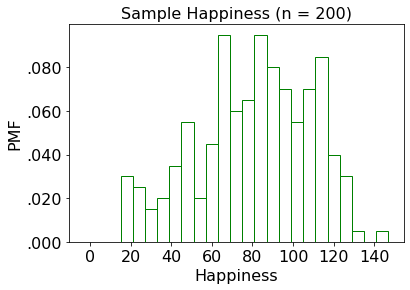

In [ ]:
print(sample) # these are the datapoints we have to work with
fig4 = plt.figure(4)
plot_sample(fig4, sample, "happiness", binwidth=6,norm=True)

## Step 5.2. Repeat bootstrapping procedure 10,000 times

We want to determine a distribution over the *sample variance* statistic.

In [ ]:
"""
S^2 = 1/(n-1) * \sum_{i=1}^n (X_i - \bar{X})^2
"""
def sample_variance(data):
    tot_dev = 0
    sample_mean = np.mean(data)
    n = len(data)
    for s in data:
        tot_dev += (s - sample_mean) ** 2
    return tot_dev/(n - 1)

### Let's do this one as a group.

Let's implement the below two cells.

If you have issues, make sure you run the very first cell in this notebook—and the previous cell that defines the `sample_variance` function!

In [ ]:
"""
Create a sample of size n from data
"""
def resample(data, n):
    return np.random.choice(data, n, replace = True)

In [ ]:
print("Starting bootstrap...")
sample_variance_boots = []
for i in range(10000): 
    sofs = resample(sample, len(sample))
    var_sofs = sample_variance(sofs)
    sample_variance_boots.append(var_sofs)
print("Finished bootstrap")

Starting bootstrap...
Finished bootstrap


In [ ]:
print(sample_variance_boots)
print(len(sample_variance_boots))

[758.7165577889451, 732.9085175879397, 843.3543718592965, 744.2602763819098, 874.5873115577889, 785.8282412060299, 840.0482160804013, 801.6542462311561, 793.1111557788945, 780.7638190954768, 887.1392964824115, 905.3949497487444, 637.82851758794, 653.6843216080407, 792.7274120603013, 723.173768844221, 717.7983668341709, 805.2864321608039, 763.8689447236183, 809.2580653266332, 820.8140703517593, 766.7103266331659, 796.9736432160807, 737.8037939698494, 955.8693467336676, 850.8300502512566, 810.0781658291455, 685.2108291457283, 795.9597989949749, 863.0673115577894, 844.0928643216076, 714.2914572864325, 748.7424874371864, 906.9658040201006, 898.0879396984925, 760.3114572864317, 850.5, 850.501884422111, 735.8467336683415, 790.621005025126, 836.9041206030156, 760.3185678391962, 847.1537437185925, 852.190954773869, 757.1919346733669, 794.6124371859296, 753.6576633165829, 858.4521608040204, 807.8456281407044, 711.1682412060301, 864.2250251256282, 775.717361809045, 769.5150753768844, 651.2441206

## Step 5.3. You now have a distribution of your statistic.

/content/util.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str('%.2f' % x)[1:4] for x in ax.get_yticks()], fontsize=16)
/content/util.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(int, ax.get_xticks()), fontsize=16)


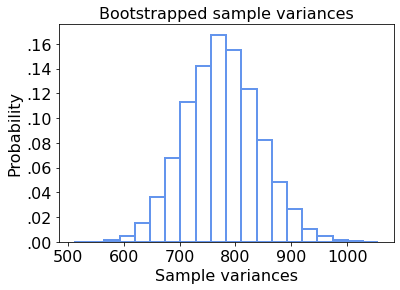

In [ ]:
fig = plt.figure(4)
plot_bootstrapped_variances(fig, sample_variance_boots)

Interestingly, the distribution of the random variable $S^2$ is not a normal distribution; it is what we call a chi-squared ($\chi^2$) distribution, which we do not study in detail in CS109.

The most important part about bootstrapping is that after this procedure, we can report a bootstrapped statistic of our sample variance, $S^2$. To report the bootstrapped standard deviation of $S^2$:

In [ ]:
print('Bootstrapped standard deviation of sample variance', np.std(sample_variance_boots))

Bootstrapped standard deviation of sample variance 65.6966520209035


# 6. Bootstrapping for p-values

Sample mean 3.1102168673436803


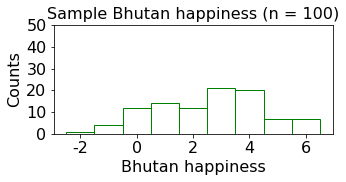

Sample mean 2.4255864511243117


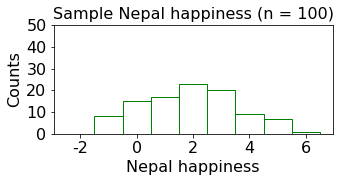

[4.45455688634, 2.45618959885, 6.36903723149, 2.070805339, 3.75533363314, 4.38233780396, 4.05337294303, 5.37817799922, 5.57120682948, 3.89222547321, 4.19076121847, 4.22226603794, 7.59242778933, 3.00095127181, 1.21615509118, 0.596463235446, 1.07617570328, 6.68204855081, 3.65922595108, 4.39317185831, 3.74666207385, 0.141602235917, 6.64566696968, 5.38886999031, 2.9573490969, 2.17495371127, -0.0406843552658, 4.51861331884, 6.81030361261, 3.14304133202, 4.89807582884, 0.452724767276, 4.28340094448, 4.01445533286, 1.15037770554, 4.48410603183, 3.66177461435, 1.48195287252, 1.50404618634, 4.35834510121, 1.34576302324, 3.8083507874, 3.58162131186, 3.21303210633, 4.06661626947, 3.82129319614, 3.18134582483, 5.95451054593, 3.20133402131, -0.223313651826, 3.3474495932, 4.05912253308, 3.34950645275, 3.64364762587, 4.86836352747, 0.521969172613, 0.916749444074, 3.10303952061, 6.24263848473, -0.0825934402442, 1.96556663081, 5.73716733579, 0.872573549321, 2.21088416481, -0.161246807083, 1.78590820664

In [ ]:
# load our data
with open('p1.csv', 'r') as f:
    sample1 = [float(line.strip()) for line in f.readlines()]
with open('p2.csv', 'r') as f:
    sample2 = [float(line.strip()) for line in f.readlines()]
    
fig7 = plt.figure(7, figsize=(5,2))
plot_sample(fig7, sample1, "Bhutan happiness", binwidth=1, binmin=-2, binmax=8)
fig8 = plt.figure(8, figsize=(5,2))
plot_sample(fig8, sample2, "Nepal happiness", binwidth=1, binmin=-2, binmax=8)

print(sample1)
print(sample2)
# record observed difference
observed_diff = abs(np.mean(sample1) - np.mean(sample2))
print("Observed difference:", observed_diff)

## Step 6.1. Create a universal sample using your two samples

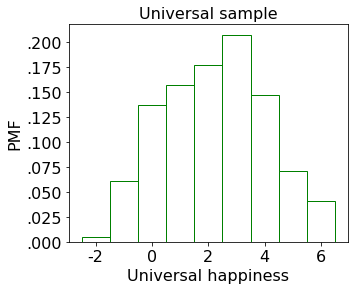

In [ ]:
# make the universal population
universal_sample = copy.deepcopy(sample1)
universal_sample.extend(sample2)

fig9 = plt.figure(9, figsize=(5,4))
plot_sample(fig9, universal_sample, "Universal happiness", binwidth=1, binmin=-2, binmax=8, title="Universal sample", norm=True)

## Step 6.2. Repeat bootstrapping procedure 10,000 times

## One Final Group Exercise

Let's fill in the cell below together.

If you have issues, make sure you run the very first cell in this notebook!


In [ ]:
# from previous cells, included here for reference
# save original diff
observed_diff = abs(np.mean(sample1) - np.mean(sample2))
ITERATIONS = 10000
count = 0
visualization_dist = []
universal_sample = copy.deepcopy(sample1)
universal_sample.extend(sample2)
print("Starting bootstrap...")
for i in range(ITERATIONS):
    # a. resample
    resample1 = resample(universal_sample, len(sample1))
    resample2 = resample(universal_sample, len(sample2))
    diff = abs(np.mean(resample1) - np.mean(resample2))
    if diff >= observed_diff: count += 1
    # just for visualization, if your statistic is called diff
    visualization_dist.append(diff)
print('Finished bootstrap')

Starting bootstrap...
Finished bootstrap


## Step 6.3. Compute the bootstrapped p-value

In [ ]:
p = count/ITERATIONS
print('p-value', p)

p-value 0.009


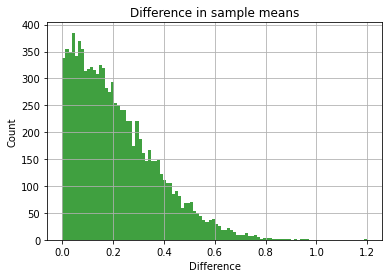

In [ ]:
fig5 = plt.figure(5)
plot_bootstrapped_differences(fig5, visualization_dist, 100, "Difference in sample means")